In [1]:

import sys
sys.path.append('..')
import json 
import os 
import pandas as pd 
import numpy as np 
import analysis_utils
import importlib 
from matplotlib.pylab import plt 
import importlib
import analysis_utils
from matplotlib.pylab import plt 
import seaborn as sns 
import numpy as np
import os
import json
import pandas as pd
import analysis_utils
import random
from scipy.stats import pearsonr, spearmanr
from scipy.stats import wasserstein_distance_nd

import marshaling.process_model as model_utils

%matplotlib inline

In [2]:
''' 
Model paths
'''

BACKGROUND_TYPE = "explicit" # implicit or explicit
# BACKGROUND_TYPE = "implicit" # implicit or explicit


if BACKGROUND_TYPE == 'explicit': 
    SYNTHESIS_MODEL_DIR = f"../marshaling-experiments/explicit-cogsci/" 
else: 
    SYNTHESIS_MODEL_DIR = f"../marshaling-experiments/experiments_feb_1_skill_to_effort_implicit/" 
    

# inference parameters
# burn_in = 1000
burn_in = 0 # Burn in is now built in
subsample = -1
filter_on_sketch_score = False
run_ablated_samples = False
n_queries = 8
print_filtered_files = False

compute_win_by_how_much_normalizer = True
COMPUTE_WIN_BY_HOW_MUCH_NORMALIZER = True 

model = "Meta-Llama-3.1-70B-Instruct-Turbo"
model_dirs = [pth for pth in os.listdir(SYNTHESIS_MODEL_DIR) if ".DS" not in pth]
domain_sels = [
        'tug-of-war',
        'canoe-race',
        # 'diving',
        'biathalon'
    ]
source2viz_txt = {'model_full': '\\textbf{MSA}', 'vanilla': 'Vanilla', 'cot': 'CoT', 'human_no_commentary': 'Human',  'gold': 'Gold'}
ordered_sports = ['tug-of-war', 'canoe-race','biathalon']#,'diving']
ordered_query_types = ['skill', 'effort', 'match']


query_type_subsets = {'skill': [0, 1, 2], 'latent': [3,4,5], 'match': [6,7]}

sources = [
    'vanilla', 'cot', 
           'model_full'
           ]

STIMULI_SUFFIX = f"{BACKGROUND_TYPE}_continuous_variable" # suffix on the stimuli scenarios
N_QUERIES = 8 
LOAD_SYNTHESIS_MODEL_DATA = True
skip_scenarios = set()
synthesis_model_data = dict() # scenario: [{samples per query}, ... per compiled model] 
    

In [3]:
''' 
Load in the human multi-click data
'''
    
model_descr = BACKGROUND_TYPE 
using_commentary = False

skip_scenarios_bug_base = {"canoe-race_effort_team-confounded-opponent-11-dec_win_how_much",
                      "tug-of-war_effort_team-confounded-opponent-11-dec_win_how_much",
                      "biathalon_shooting-accuracy_team-confounded-opponent-11-dec_win_how_much"}

skip_scenarios_bug = [f'{scenario}_{model_descr}_continuous_variable' for scenario in skip_scenarios_bug_base]
    
if using_commentary: 
    phase_dir = "phase-3"
    correction_tag = ''
else: 
    phase_dir = "phase-1"
    correction_tag = f'_{model_descr}_continuous_variable'
h_data_pth = f"../human-experiments/{phase_dir}/multiclick_scenario_res_{model_descr}.json"

# h_data_pth2 = f"../human-experiments/phase-1/multiclick_scenario_res_{model_descr}.json"

with open(h_data_pth, "r") as f: 
    # For some reason these are missing the suffix
    baseline_human_data = {k + correction_tag : v for k, v in json.load(f).items()}
    
baseline_human_data.keys()

for key in skip_scenarios_bug: 
    if key not in baseline_human_data: continue
    del baseline_human_data[key]


''' 
Load in the full written scenario
'''
if using_commentary:
    base_scenarios_dir = "../scenarios/model-readable/scenarios-commentary/"
else:
    base_scenarios_dir = '../scenarios/model-readable/'

stim2txt = {scenario: "" for scenario in baseline_human_data.keys()}
for stim_id in stim2txt: 
    if stim_id[0] == ".": stim_id = stim_id[1:]
    stim_file = f"{base_scenarios_dir}{stim_id}.txt"
    with open(stim_file, "r") as f: res = f.readlines()
    stim2txt[stim_id] = res

In [4]:
for k, v in baseline_human_data.items():
    print(k, "\n", len(v))

diving_difficulty_team-explain-away-diverse-confounded-partner-dec_win_how_much_explicit_continuous_variable 
 19
canoe-race_effort_team-confounded-opponent-12-dec_win_how_much_explicit_continuous_variable 
 19
canoe-race_effort_team-strong-indirect-14-dec_win_how_much_explicit_continuous_variable 
 20
biathalon_shooting-accuracy_team-explain-away-confounded-opponent-partner-dec_win_how_much_explicit_continuous_variable 
 19
canoe-race_effort_team-explain-away-11-dec_win_how_much_explicit_continuous_variable 
 19
canoe-race_effort_team-confounded-partner-10-dec_win_how_much_explicit_continuous_variable 
 18
tug-of-war_effort_team-confounded-opponent-12-dec_win_how_much_explicit_continuous_variable 
 19
canoe-race_effort_team-explain-away-confounded-opponent-partner-dec_win_how_much_explicit_continuous_variable 
 18
biathalon_shooting-accuracy_team-explain-away-11b-dec_win_how_much_explicit_continuous_variable 
 18
tug-of-war_effort_team-explain-away-diverse-confounded-partner-dec_win_h

In [5]:
''' 
Load LLMs 
'''
llm_prompt_types = ['cot', 'vanilla']
llm_res = {prompt_tag: {} for prompt_tag in llm_prompt_types}
for prompt_type in llm_prompt_types: 
    with open(f"../llm-experiments/phase-1/{prompt_type}.json", "r") as f: 
        # For some reason these are missing the suffix
        llm_res[prompt_type] = {}
        for k, v in json.load(f).items(): 
            if model_descr == 'explicit' and "implicit" in k: continue 
            elif model_descr == 'implicit' and "implicit" not in k: continue 
            k += f'_{model_descr}_continuous_variable'
            llm_res[prompt_type][k.split("_continuous_variable")[0] + "_continuous_variable"] = v 
        
        #llm_res[prompt_type] = {k + f'_{model_descr}_continuous_variable' : v for k, v in json.load(f).items()}
        print(prompt_type)
        print(len(llm_res[prompt_type]))

cot
21
vanilla
21


In [6]:
debug_print = False
skip_scenarios = set()
synthesis_model_data = dict() # scenario: [{samples per query}, ... per compiled model] 
    
# Load the synthesis models regardless, since we'll use them to determine comparable gold models.
for mdir in model_dirs:
    scenario = mdir.split(f"_{model}")[0]
    scenario_domain = scenario.split("_")[0]
    if scenario_domain in domain_sels:
        full_pth = f"{SYNTHESIS_MODEL_DIR}{mdir}/"
        inference_files = [pth for pth in os.listdir(full_pth) if "inference_" in pth]
        synthesis_model_data[scenario] = []

        if LOAD_SYNTHESIS_MODEL_DATA:
            if debug_print: print(f"Loading synthesis model data for: {scenario}")
            for inference_file in inference_files:
                if debug_print: print(f"Loading in inference file: {inference_file}")
                try: 
                    if debug_print: print("inference file: ", inference_file)
                    processed_samples = analysis_utils.load_and_process_samples_from_inference_results(
                            inference_results_path=full_pth, inference_file=inference_file, who_would_win_baseline_n_samples=20000, who_would_win_baseline_n_samples_timeout=240, query_7_8_take_negative=False,
                            n_queries=N_QUERIES
                        )
                    synthesis_model_data[scenario].append(processed_samples)  
                except: 
                    
                    continue
            if len(synthesis_model_data[scenario]) == 0: skip_scenarios.add(scenario)
            
all_inference_data = synthesis_model_data

In [7]:
debug_print = False
skip_scenarios = set()
gold_model_data = dict() # scenario: [{samples per query}, ... per compiled model] 
    
GOLD_MODEL_DIR = "../marshaling-experiments/experiments_feb_2_skill_to_effort_explicit_gold/"
gold_model_dirs = [pth for pth in os.listdir(GOLD_MODEL_DIR) if ".DS" not in pth]

    
# Load the synthesis models regardless, since we'll use them to determine comparable gold models.
for mdir in gold_model_dirs:
    scenario = mdir.split(f"_{model}")[0]
    scenario_domain = scenario.split("_")[0]
    if scenario_domain in domain_sels:
        full_pth = f"{GOLD_MODEL_DIR}{mdir}/"
        inference_files = [pth for pth in os.listdir(full_pth) if "inference_" in pth]
        if BACKGROUND_TYPE == 'implicit': 
            scenario = scenario.replace('explicit', 'implicit')
        gold_model_data[scenario] = []

        if LOAD_SYNTHESIS_MODEL_DATA:
            if debug_print: print(f"Loading synthesis model data for: {scenario}")
            for inference_file in inference_files:
                if debug_print: print(f"Loading in inference file: {inference_file}")
                try: 
                    if debug_print: print("inference file: ", inference_file)
                    processed_samples = analysis_utils.load_and_process_samples_from_inference_results(
                            inference_results_path=full_pth, inference_file=inference_file, who_would_win_baseline_n_samples=20000, who_would_win_baseline_n_samples_timeout=240, query_7_8_take_negative=False,
                            n_queries=N_QUERIES
                        )
                    gold_model_data[scenario].append(processed_samples)  
                except: 
                    
                    continue
            if len(gold_model_data[scenario]) == 0: skip_scenarios.add(scenario)
            
all_gold_data = gold_model_data

In [8]:
''' 
# process the values 
# structure it so that we have a key for each "source"
'''
use_human_data = True
using_commentary = False
use_llms = True
use_gold = False

skip_models = False

sources = ['human_no_commentary']

if not skip_models: sources.extend(['model_full', 'gold'])

if use_llms: sources.extend(llm_prompt_types)


all_scenarios = list(baseline_human_data.keys()) #list(all_inference_data.keys())

per_participant_vec = {source: {scenario: [] for scenario in all_scenarios} for source in sources}
n_queries= 8
for source in sources: 
    for scenario in all_scenarios:
        if 'diving' in scenario or scenario in skip_scenarios_bug: continue         
        #print(scenario)
        if "model" in source: 
            model_type = source.split("_")[-1]
            #print(scenario)
            if scenario not in all_inference_data:
                print('missing from synth runs: ', scenario)
                continue
            
            entries = [m[model_type] for m in all_inference_data[scenario] if m is not None and model_type in m]
            #entries = [x['full'] for x in entries]
            # print(entries)
        elif "human_commentary" in source: 
            entries = human_data[scenario]
        elif "human_no_commentary" in source: 
            entries = baseline_human_data[scenario]
        elif 'gold' in source: 
            #scenario_tag = scenario.split("_implicit")[0]
           #print(scenario_tag)
            if scenario not in all_gold_data: 
                print(scenario)
                continue
            entries = [x['full'] for x in all_gold_data[scenario] if x is not None]
        else: 
            if scenario in llm_res[source]:
                entries = llm_res[source][scenario]
            else: entries = []
            
        for entry in entries: 
            vec = []
            skip_entry = False
            if entry is None: continue
            for query_idx in range(n_queries): 
                if f'query{query_idx+1}' not in entry: 
                    skip_entry = True 
                    continue
                vals = entry[f'query{query_idx+1}']
                if len(vals) == 0: 
                    #print('participant didnt click each time, skipping: ', source, query_idx)
                    skip_entry = True
                    break
                vec.append(vals)
            if not skip_entry: per_participant_vec[source][scenario].append(vec)


In [9]:
# all_gold_data['biathalon_shooting-accuracy_team-strong-indirect-14-dec_win_how_much_explicit_continuous_variable']#.keys()

In [10]:

# importlib.reload(analysis_utils)
# processed_vals_all_srcs =analysis_utils.process_values_from_all_sources(
#     all_scenarios=all_scenarios,
#     llm_res=llm_res,
#     baseline_human_data=baseline_human_data,
#     all_inference_data=all_inference_data,
#     gold_inference_data=None,
#     n_queries=n_queries,
#     method="flat"
# )



In [11]:
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import wasserstein_distance, wasserstein_distance_nd
import itertools

def subsample_scenario_data(scenario_data, sample_frac=0.5, replace=False):
    
    n_samples = len(scenario_data)
    sample_size = int(n_samples * sample_frac)
    indices = np.random.choice(n_samples, sample_size, replace=replace)
    return [scenario_data[i] for i in indices], indices

def single_bootstrap_r2(per_participant_vec, sources, subdomains, query_type_subsets):
    
    
    processed_data = {}
    
    for source in sources:
        processed_data[source] = {}
        
        for domain in subdomains:
            for query_type, idxs in query_type_subsets.items():
                source1_vals = []
                source2_vals = []
                
                for scenario in all_scenarios:
                    scenario_domain = scenario.split('_')[0]
                    if scenario_domain != domain:
                        continue
                        
                    if 'human' in source: 
                        # then we're in human-human split 
                        
                        s2, bootstrap_idxs = subsample_scenario_data(per_participant_vec['human_no_commentary'][scenario])
                        s1 = [entry for idx, entry in enumerate(per_participant_vec[source][scenario]) if idx not in bootstrap_idxs]
                    else: 
                        s1 = per_participant_vec[source][scenario]
                        s2, bootstrap_idxs = subsample_scenario_data(per_participant_vec['human_no_commentary'][scenario], sample_frac=1.0, replace=True)
                    
                    # for query_idx in idxs:
                    #     participant_values1 = [value for entry in s1 if len(entry[query_idx]) != 0 for value in entry[query_idx]]
                    #     participant_values2 = [value for entry in s2 if len(entry[query_idx]) != 0 for value in entry[query_idx]]
                    for query_idx in idxs:
                        participant_values1 = [np.mean(entry[query_idx]) for entry in s1 if len(entry[query_idx]) != 0 ]#for value in entry[query_idx]]
                        participant_values2 = [np.mean(entry[query_idx]) for entry in s2 if len(entry[query_idx]) != 0 ]#for value in entry[query_idx]]
                        
                        if str(np.mean(participant_values1)) == 'nan':
                            #print("nan: ", participant_values1, s1, scenario)
                            continue
                        
                        m1 = np.mean(participant_values1)
                        m2 = np.mean(participant_values2)
                        
                        source1_vals.append(m1)
                        source2_vals.append(m2)
                
                if len(source1_vals) != 0 and len(source2_vals) != 0:
                    corr, _ = pearsonr(source1_vals, source2_vals)
                    r2 = corr ** 2
                    
                    dist = np.mean([np.abs(m1 - m2) for m1, m2 in zip(source1_vals, source2_vals)])
                    
                    # if 'human' in source and dist > 11: 
                    #     print([np.abs(m1 - m2) for m1, m2 in zip(source1_vals, source2_vals)], all_scenarios)
                    
                    # if 'human' in source: 
                    #     if r2 < 0.2: 
                    #         print("indices")
                    
                    key = f"{domain}-{query_type}"
                    processed_data[source][key] = r2
                    
                    #processed_data[source][key] = dist
     
    return processed_data



def single_bootstrap_wd(per_participant_vec, sources, subdomains, query_type_subsets, bins=10, mode='centroid'):
    
    
    processed_data = {}
    multidim_wd_data = {}
    
    
    for source in sources:
        processed_data[source] = {}
        multidim_wd_data[source] = {}
        
        for domain in subdomains:
            for scenario in all_scenarios:
                scenario_domain = scenario.split('_')[0]
                if scenario_domain != domain:
                    continue
                
                processed_data[source][scenario] = {}
                multidim_wd_data[source][scenario] = None
            
                
                histograms_s1 = {}
                histograms_s2 = {}
                
                
                
                if 'human' in source: 
                    # then we're in human-human split 
                    s2, bootstrap_idxs = subsample_scenario_data(per_participant_vec['human_no_commentary'][scenario])
                    s1 = [entry for idx, entry in enumerate(per_participant_vec[source][scenario]) if idx not in bootstrap_idxs]
                else: 
                    s1 = per_participant_vec[source][scenario]
                    s2, bootstrap_idxs = subsample_scenario_data(per_participant_vec['human_no_commentary'][scenario], sample_frac=1.0, replace=True)
                    
                vecs_s1 = np.zeros([n_queries, len(s1)])
                vecs_s2 = np.zeros([n_queries, len(s2)])
                
                for query_type, idxs in query_type_subsets.items():
    
                    for query_idx in idxs:
                        participant_values1 = [value for entry in s1 if len(entry[query_idx]) != 0 for value in entry[query_idx]]
                        participant_values2 = [value for entry in s2 if len(entry[query_idx]) != 0 for value in entry[query_idx]]
                        
                        vecs_s1[query_idx, :] = [np.mean(entry[query_idx]) for entry in s1 if len(entry[query_idx]) != 0]
                        vecs_s2[query_idx, :] = [np.mean(entry[query_idx]) for entry in s2 if len(entry[query_idx]) != 0]
                        
                        
                    # for query_idx in idxs:
                    #     participant_values1 = [np.mean(entry[query_idx]) for entry in s1 if len(entry[query_idx]) != 0 ]#for value in entry[query_idx]]
                    #     participant_values2 = [np.mean(entry[query_idx]) for entry in s2 if len(entry[query_idx]) != 0 ]#for value in entry[query_idx]]
                        
                        if str(np.mean(participant_values1)) == 'nan':
                            #print("nan: ", participant_values1, s1, scenario)
                            continue
                        
                        
                        hist1, bin_edges = np.histogram(participant_values1, bins=bins, range=(0, 100), density=True)
                        hist2, _ = np.histogram(participant_values2, bins=bins, range=(0, 100), density=True)
                        
                        histograms_s1[query_idx] = hist1 #[v/len(vals1) for v in hist1]
                        histograms_s2[query_idx] = hist2 #[v/len(vals2) for v in hist2]
                        # if show_plots:
                        #     fig, ax = plt.subplots()
                        #     ax.hist(vals1, bins=bins, range=(0, 100), density=True, alpha=0.5)
                        #     ax.hist(vals2, bins=bins, range=(0, 100), density=True, alpha=0.5)
                        #     plt.title(f"{scenario}\n{query_idx}")
                            
                        # Compute WD for this query
                        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
                        wd = wasserstein_distance(bin_centers, bin_centers, hist1, hist2)
                        processed_data[source][scenario][query_idx] = wd
                
                                
                    
                    if histograms_s1 and histograms_s2:
                        
                        
                        if mode == 'centroid': 
                            
                            centroid = np.mean(vecs_s2, axis=1) # (8,1)
                            multi_scores = []
                            for participant_vec in vecs_s1:    
                                multidim_wd = wasserstein_distance_nd(participant_vec, centroid)
                                multi_scores.append(multidim_wd)
                            multidim_wd_data[source][scenario] = np.mean(multi_scores)                   
                            
                        else: 
                        
                            u = np.array([histograms_s1[k] for k in histograms_s1.keys()])
                            v = np.array([histograms_s2[k] for k in histograms_s2.keys()])
                            # print(u.shape, v.shape)
                            multidim_wd = wasserstein_distance_nd(u, v)
                        multidim_wd_data[source][scenario] = multidim_wd
                        
    return processed_data, multidim_wd_data




# Example usage:
subdomains = {'canoe-race', 'biathalon', 'tug-of-war'}#, 'diving'}
query_type_subsets = {'skill': [0, 1, 2], 'effort': [3,4,5], 'match': [6,7]}
sources = ['human_no_commentary', 'gold',   'model_full', 'vanilla', 'cot', ]

# all_wd_dists, all_multidim_wd_dists = single_bootstrap_wd(per_participant_vec, sources, subdomains, query_type_subsets, bins=10)

In [12]:
subsample_scenario_data(per_participant_vec['human_no_commentary'][scenario], sample_frac=1.0, replace=True)

([[[54, 93, 89, 84, 63],
   [61, 94, 91, 85, 78],
   [50, 75, 70, 53, 58],
   [24, 28, 75, 81, 86],
   [29, 34, 79, 83, 88],
   [82, 87, 92, 98, 72],
   [70, 77, 89, 93, 98],
   [23, 26, 66, 71, 75]],
  [[29, 24, 19, 14, 21],
   [44, 38, 33, 28, 31],
   [47, 52, 57, 62, 54],
   [83, 79, 83, 88, 85],
   [60, 64, 68, 71, 66],
   [53, 47, 45, 41, 43],
   [62, 67, 70, 76, 74],
   [28, 21, 17, 11, 24]],
  [[73, 66, 59, 50, 55],
   [76, 49, 53, 71, 61],
   [37, 24, 51, 45, 30],
   [42, 31, 36, 50, 60],
   [22, 51, 43, 28, 35],
   [100, 95, 83, 75, 91],
   [25, 11, 34, 29, 15],
   [45, 54, 65, 34, 50]],
  [[21, 22, 26, 30, 33],
   [62, 62, 64, 64, 67],
   [20, 23, 31, 73, 74],
   [81, 81, 81, 72, 64],
   [29, 33, 48, 55, 61],
   [26, 37, 66, 66, 56],
   [20, 28, 31, 37, 43],
   [30, 47, 54, 63, 73]],
  [[29, 24, 19, 14, 21],
   [44, 38, 33, 28, 31],
   [47, 52, 57, 62, 54],
   [83, 79, 83, 88, 85],
   [60, 64, 68, 71, 66],
   [53, 47, 45, 41, 43],
   [62, 67, 70, 76, 74],
   [28, 21, 17, 11, 

In [13]:
n_bootstrap_samples = 10#0#00

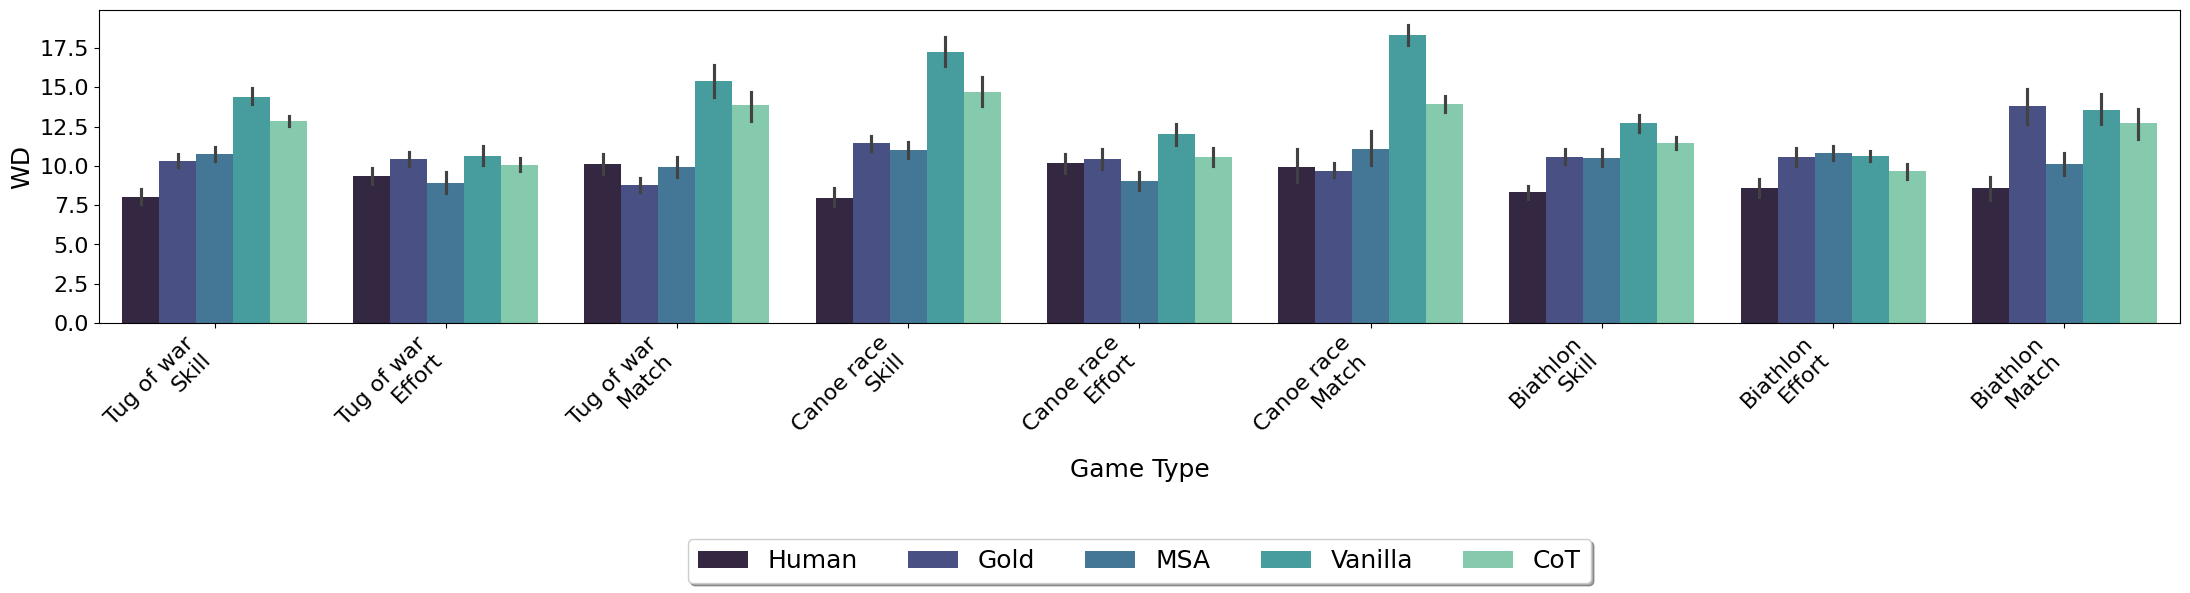

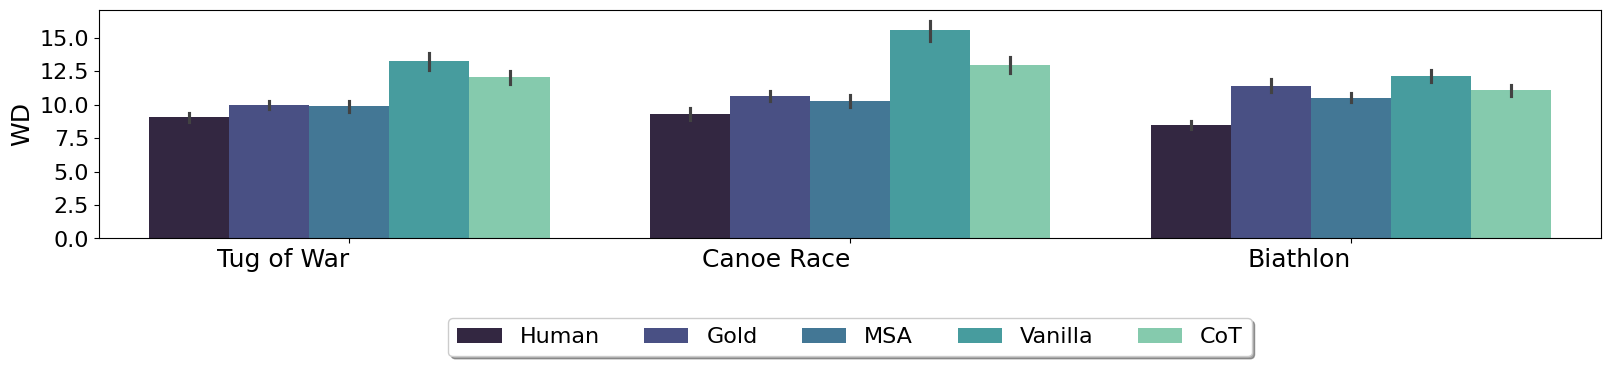

In [14]:
# Per-query WD analysis
wd_res = {
    'source': [],
    'query': [],
    'domain': [],
    'score': []
}

wd_res_stim = {
    'source': [],
    'query': [],
    'domain': [],
    'score': [],
    'stim': []
}

multi_wd_res = {
    'source': [],
    'domain': [],
    'score': []
}

multi_wd_res_stim = {
    'source': [],
    'domain': [],
    'score': [], 
    'stim': []
}


sport2viz = {
        'tug-of-war': 'Tug of War', 
        'canoe-race': 'Canoe Race', 
        'biathalon': 'Biathlon'
    }
    
multidim_query_mode = 'centroid' # MODULATE TO CONTROL WHAT KIND OF 8-DIM WD WE CONSIDER

for _ in range(n_bootstrap_samples): 

    # run one round of WDs over a single bootstrap subsample
    all_wd_dists, all_multidim_wd_dists = single_bootstrap_wd(per_participant_vec, sources, subdomains, query_type_subsets, bins=10, mode=multidim_query_mode)

    # process the data -- NOTE messy! 
    src1 = 'human_no_commentary'
    for domain_sel in domain_sels:
        # Dictionary to store scores for averaging across query types
        domain_scores = {'Human': []}
        for src in sources:
            if src != src1:
                src_txt = "MSA" if src == 'model_full' else source2viz_txt[src]
                domain_scores[src_txt] = []
        
        for query_type, queries in query_type_subsets.items():
            for query in queries:
                
                for j, src2 in enumerate(sources):
                    scores = [] # all scores per scenario
                    for stim in all_scenarios:
                        domain = stim.split('_')[0]
                        if domain_sel != 'all':
                            if domain != domain_sel: 
                                continue
                        
                        try: 
                            score = all_wd_dists[src2][stim][query]
                            scores.append(score)
                            # save out stimuli data for deeper dive
                            wd_res_stim['source'].append(src_txt)
                            wd_res_stim['query'].append(query_type)
                            wd_res_stim['score'].append(score)
                            wd_res_stim['domain'].append(sport2viz[domain_sel])
                            wd_res_stim['stim'].append(stim)
                        except Exception as e: 
                            print('stim exception: ', e )
                            continue 
                    
                    if len(scores) > 0:
                        src_txt = source2viz_txt[src2] if src2 != 'model_full' else "MSA"
                        mean_score = np.mean(scores) # average over scenarios
                        wd_res['source'].append(src_txt)
                        wd_res['query'].append(query_type)
                        wd_res['score'].append(mean_score)
                        wd_res['domain'].append(sport2viz[domain_sel])
                        domain_scores[src_txt].append(mean_score)
        
        # # Add averaged scores for each domain
        # # TODO --- maybe add a query label that we incorporate --- right now this averages over the averages per
        # for source, scores in domain_scores.items():
        #     if scores:  # Only add if we have scores to average
        #         wd_res['source'].append(source)
        #         wd_res['query'].append('agg')
        #         wd_res['score'].append(np.mean(scores))
        #         wd_res['domain'].append(domain_sel)
    
    
    for domain_sel in domain_sels:
        for j, src2 in enumerate(sources):

            scores = []
            scenario2scores = {}
            for stim in all_scenarios:
                domain = stim.split('_')[0]
                if domain_sel != 'all':
                    if domain != domain_sel: 
                        continue
                
                if stim not in all_multidim_wd_dists[src2]:
                    continue
                    
                score = all_multidim_wd_dists[src2][stim]
                scores.append(score)
                scenario2scores[stim] = score
                multi_wd_res_stim['source'].append(src_txt)
                multi_wd_res_stim['score'].append(score)
                multi_wd_res_stim['domain'].append(sport2viz[domain_sel])
                multi_wd_res_stim['stim'].append(stim)
            # print(src2, scenario2scores, scores)
            
            src_txt = source2viz_txt[src2] if src2 != 'model_full' else "MSA"
            multi_wd_res['source'].append(src_txt)
            multi_wd_res['score'].append(np.mean(scores))
            multi_wd_res['domain'].append(sport2viz[domain_sel])

# Create visualization
wd_df = pd.DataFrame.from_dict(wd_res)
wd_df['tag'] = [f'{domain.capitalize()}\n{query.capitalize()}' 
                for domain, query in zip(wd_df['domain'], wd_df['query'])]

order_sources = ['Human', 'Gold', 'MSA', 'Vanilla', 'CoT']
palette = sns.color_palette("mako", n_colors=len(order_sources))

fig, ax = plt.subplots(figsize=(22,8))
sns.barplot(data=wd_df,
            x="tag",
            y="score",
            hue="source",
            ax=ax,
            errorbar=("ci", 95),
            hue_order=order_sources,
            palette=palette)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.65),
            ncol=6, fancybox=True, shadow=True, fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=16)
ax.set_xlabel("Game Type", fontsize=18)
ax.set_ylabel("WD", fontsize=18)
plt.tight_layout()
plt.savefig(f"per_sport_query_wd_{model_descr}.pdf", dpi=300)


multi_wd_df = pd.DataFrame.from_dict(multi_wd_res)
fig, ax = plt.subplots(figsize=(16,4))

# NOTE: if you set multi_wd_df here to be wd_df, it will average over runs
sns.barplot(data=wd_df,
            x="domain",
            y="score",
            hue="source",
            ax=ax,
            errorbar=("ci", 95),
            hue_order=order_sources,
            palette=palette)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
            ncol=6, fancybox=True, shadow=True, fontsize=16)
plt.xticks(ha='right', fontsize=18)
plt.yticks(fontsize=16)
ax.set_xlabel("", fontsize=18)
ax.set_ylabel("WD", fontsize=18)
plt.tight_layout()
plt.savefig(f"per_sport_query_aggwd_{model_descr}.pdf", dpi=300)



In [15]:
# multi_wd_res_stim_df = pd.DataFrame(multi_wd_res_stim)
wd_res_stim_df = pd.DataFrame(wd_res_stim)
wd_res_stim_df


,source,query,domain,score,stim
0,CoT,skill,Tug of War,7.133333,tug-of-war_effort_team-confounded-opponent-12-...
1,CoT,skill,Tug of War,11.800000,tug-of-war_effort_team-explain-away-diverse-co...
2,CoT,skill,Tug of War,12.096774,tug-of-war_effort_team-confounded-partner-10-d...
3,CoT,skill,Tug of War,3.888889,tug-of-war_effort_team-round-robin-20-dec_win_...
4,CoT,skill,Tug of War,8.733333,tug-of-war_effort_team-weak-indirect-16-dec_wi...
...,...,...,...,...,...
8395,Vanilla,match,Biathlon,13.038889,biathalon_shooting-accuracy_team-confounded-pa...
8396,Vanilla,match,Biathlon,4.338462,biathalon_shooting-accuracy_team-weak-indirect...
8397,Vanilla,match,Biathlon,6.666667,biathalon_shooting-accuracy_team-strong-indire...
8398,Vanilla,match,Biathlon,13.100000,biathalon_shooting-accuracy_team-confounded-pa...


In [16]:
# for k, v in wd_res_stim.items():
#     print(k, len(v))

In [17]:
explain_away_counts = []
stim_set = set(wd_res_stim_df.stim)
for stim in stim_set: 
    # todo: check that this is computed correctly -- loop over individ questions
    stim_entries = wd_res_stim_df.loc[wd_res_stim_df.stim == stim]
    msa_score = np.mean(stim_entries.loc[stim_entries.source == 'MSA']['score'])
    cot_score = np.mean(stim_entries.loc[stim_entries.source == 'CoT']['score'])
    vanilla_score = np.mean(stim_entries.loc[stim_entries.source == 'Vanilla']['score'])
    h_score = np.mean(stim_entries.loc[stim_entries.source == 'Human']['score'])
    
    if msa_score - h_score > 5: print('msa > h: ', msa_score, h_score, stim)
    if np.abs(msa_score - h_score) < 2: print('msa approx h: ', msa_score, h_score, stim)
    
    if 'explain-away' in stim: 
        print('explain away: ', stim, msa_score, h_score)


msa > h:  16.06175438596491 8.550961842105263 canoe-race_effort_team-confounded-opponent-12-dec_win_how_much_explicit_continuous_variable
explain away:  tug-of-war_effort_team-explain-away-diverse-confounded-partner-dec_win_how_much_explicit_continuous_variable 13.548750000000002 10.749575
msa > h:  15.106790235863832 9.31913382835133 canoe-race_effort_team-strong-indirect-13-dec_win_how_much_explicit_continuous_variable
msa > h:  18.71607146300995 11.822017108135906 tug-of-war_effort_team-explain-away-confounded-opponent-partner-dec_win_how_much_explicit_continuous_variable
explain away:  tug-of-war_effort_team-explain-away-confounded-opponent-partner-dec_win_how_much_explicit_continuous_variable 18.71607146300995 11.822017108135906
msa approx h:  12.398750000000001 10.711675 biathalon_shooting-accuracy_team-strong-indirect-14-dec_win_how_much_explicit_continuous_variable
msa approx h:  12.98328348994921 12.281172902173857 biathalon_shooting-accuracy_team-weak-indirect-15-dec_win_how_

In [19]:



def generate_latex_sport_r2_with_ci(sources, ordered_sports, ordered_query_types, n_bootstrap=100):
    source2viz_txt = {
        'model_full': '\\textbf{MSA}', 
        'vanilla': 'Vanilla', 
        'cot': 'CoT', 
        'human_no_commentary': 'Human', 
        'gold': 'Gold'
    }
    
    print("sources: ", sources)
    
    # Run multiple bootstraps
    r2_data_list = []
    for _ in range(n_bootstrap):
        r2_data_list.append(single_bootstrap_r2(per_participant_vec, sources, subdomains, query_type_subsets))
    
    # Calculate stats
    stats = {}
    for source in sources: #['model_full', 'vanilla', 'cot', 'human_no_commentary']:
        stats[source] = {}
        for sport in ordered_sports:
            for query_type in ordered_query_types:
                key = f"{sport}-{query_type}"
                values = []
                for r2_data in r2_data_list:
                    if key in r2_data[source]:
                        values.append(r2_data[source][key])
                if values:
                    stats[source][key] = {
                        'mean': np.mean(values),
                        'ci': np.percentile(values, [2.5, 97.5]),
                        'vals': values
                    }
    
    latex_output = [
        "\\begin{table*}",
        "\\small",
        "\\begin{tabular}{l" + "r" * (len(ordered_sports) * len(ordered_query_types)) + "}",
        "\\toprule"
    ]
    
    # Sport headers
    sport_headers = [f"\\multicolumn{{3}}{{c}}{{{sport2viz[sport]}}}" 
                    for sport in ordered_sports]
    latex_output.append("Source & " + " & ".join(sport_headers) + " \\\\")
    
    # Query type headers
    query_headers = []
    for _ in ordered_sports:
        query_headers.extend(['Constant', 'Temporal', 'Prediction'])
    latex_output.append("& " + " & ".join(query_headers) + " \\\\ \\midrule")
    
    # Data rows
    for source in sources:
        row_cells = [source2viz_txt[source]]
        for sport in ordered_sports:
            for query_type in ordered_query_types:
                key = f"{sport}-{query_type}"
                if key in stats[source]:
                    stat = stats[source][key]
                    row_cells.append(
                        f"${round(stat['mean'], 2)}$ "
                        f"$\\scriptscriptstyle ({round(stat['ci'][0], 2)},{round(stat['ci'][1], 2)})$"
                    )
                else:
                    row_cells.append("--")
        latex_output.append(" & ".join(row_cells) + " \\\\")
    
    latex_output.extend([
        "\\bottomrule",
        "\\end{tabular}",
        "\\caption{R² values between model and human judgments with 95\\% CI. Human rows show bootstrapped human-human splits.}",
        "\\label{tab:r2_all}",
        "\\end{table*}"
    ])
    
    return "\n".join(latex_output), r2_data_list, stats

latex_table, all_r2_data, r2_stats = generate_latex_sport_r2_with_ci(sources, ordered_sports, ordered_query_types, n_bootstrap=n_bootstrap_samples)
print(latex_table)

sources:  ['human_no_commentary', 'gold', 'model_full', 'vanilla', 'cot']
\begin{table*}
\small
\begin{tabular}{lrrrrrrrrr}
\toprule
Source & \multicolumn{3}{c}{Tug of War} & \multicolumn{3}{c}{Canoe Race} & \multicolumn{3}{c}{Biathlon} \\
& Constant & Temporal & Prediction & Constant & Temporal & Prediction & Constant & Temporal & Prediction \\ \midrule
Human & $0.77$ $\scriptscriptstyle (0.66,0.87)$ & $0.48$ $\scriptscriptstyle (0.19,0.64)$ & $0.52$ $\scriptscriptstyle (0.3,0.72)$ & $0.82$ $\scriptscriptstyle (0.69,0.92)$ & $0.35$ $\scriptscriptstyle (0.19,0.55)$ & $0.63$ $\scriptscriptstyle (0.36,0.78)$ & $0.82$ $\scriptscriptstyle (0.71,0.91)$ & $0.78$ $\scriptscriptstyle (0.63,0.92)$ & $0.65$ $\scriptscriptstyle (0.35,0.83)$ \\
Gold & $0.9$ $\scriptscriptstyle (0.83,0.94)$ & $0.66$ $\scriptscriptstyle (0.55,0.76)$ & $0.78$ $\scriptscriptstyle (0.61,0.91)$ & $0.86$ $\scriptscriptstyle (0.81,0.9)$ & $0.49$ $\scriptscriptstyle (0.29,0.67)$ & $0.53$ $\scriptscriptstyle (0.41,0.62)$ & 

Text(0.5, 0, 'R$^2$')

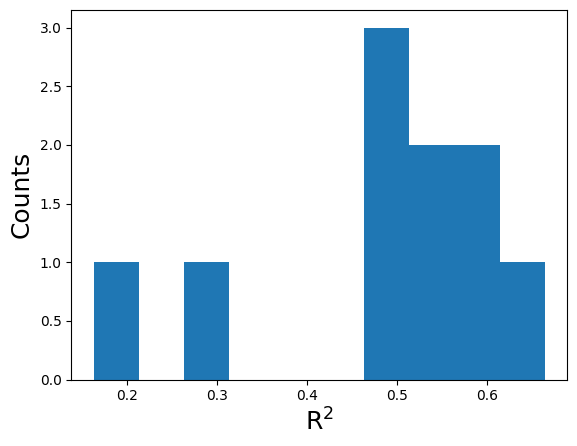

In [20]:
vals = r2_stats['human_no_commentary']['tug-of-war-effort']['vals']
plt.hist(vals)
plt.ylabel("Counts", fontsize=18)
plt.xlabel("R$^2$", fontsize=18)

In [21]:
np.mean(vals)

np.float64(0.48484405985093665)

In [22]:
print(sources)

['human_no_commentary', 'gold', 'model_full', 'vanilla', 'cot']


biathalon biathalon_shooting-accuracy_team-weak-indirect-15-dec_win_how_much_explicit_continuous_variable 64.1174998460352 30.23947368421053


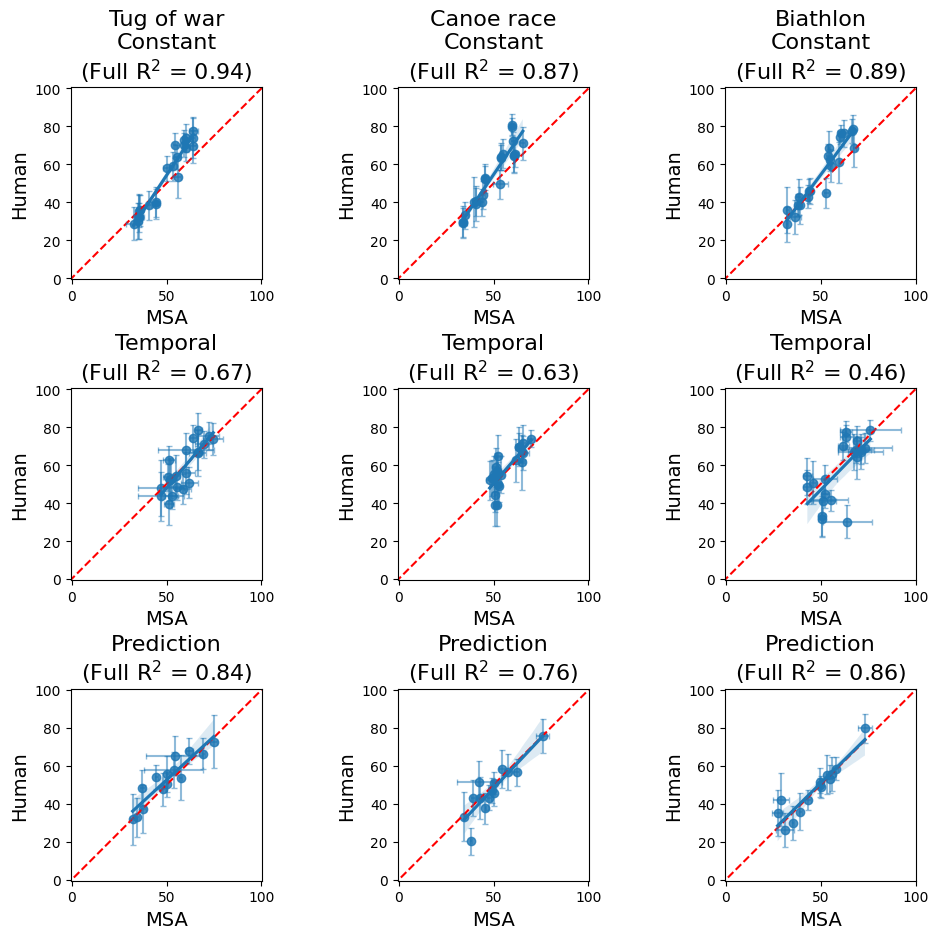

In [23]:
'''
General scatterplots -- note: still a little messy -- may want to refactor
''' 


importlib.reload(analysis_utils)

query_type_subsets = {'skill': [0, 1, 2], 'latent': [3,4,5], 'match': [6,7]}

query2viz = {'skill': 'Constant', 'latent': 'Temporal', 'match': 'Prediction'}

sources = [
    #'vanilla', 'cot', 
        #    'gold', 
           'model_full'
           ]

subdomains = ['tug-of-war', 
              'canoe-race', 
              'biathalon', 
             # 'diving'
              ]
domain_sels = subdomains

axsize = 14 
titlesize=16
for source in sources: 
    fig, axes = plt.subplots(3,len(domain_sels),figsize=(10,10))

    for domain_idx, domain_sel in enumerate(domain_sels): 

        for i, (query_type, idxs) in enumerate(query_type_subsets.items()): 
            # ax = axes[domain_idx][i]
            ax = axes[i][domain_idx]
            
            source1_vals = []
            source2_vals = []
            
            source1_se = []
            source2_se = []
            
            for scenario in all_scenarios:
                #if 'explain' in scenario: continue
                
                domain = scenario.split('_')[0]
                
                if domain_sel == 'all': 
                    if domain not in subdomains: continue
                else: 
                    if domain not in domain_sel: continue
                        
                s2 = per_participant_vec['human_no_commentary'][scenario]
                s1 = per_participant_vec[source][scenario]
                    
                for query_idx in idxs: 
                    
                    # get the "mean" of the multi-click (or multi-sample from inference)
                    participant_values1 = [np.mean(entry[query_idx]) for entry in s1 if len(entry[query_idx]) != 0 ]
                    participant_values2 = [np.mean(entry[query_idx]) for entry in s2 if len(entry[query_idx]) != 0 ]
                    
                    # participant_values1 = [value for entry in s1 if len(entry[query_idx]) != 0 for value in entry[query_idx]]
                    # participant_values2 = [value for entry in s2 if len(entry[query_idx]) != 0 for value in entry[query_idx]]
                    
                    if str(np.mean(participant_values1)) == 'nan':
                         
                        print("nan: ", participant_values1, s1, scenario)
                        continue
                    
                    m1 = np.mean(participant_values1)
                    m2 = np.mean(participant_values2)
                    
                    source1_vals.append(m1)
                    source2_vals.append(m2)
                    
                    if query_type == 'latent': 
                        if np.abs(m1-m2) > 30: print(domain_sel, scenario, m1, m2)
                    
                    
                    source1_se.append(analysis_utils.compute_se(participant_values1)) #s1[query_idx]))
                    source2_se.append(analysis_utils.compute_se(participant_values2))#s2[query_idx]))
                
            #print(len(source1_vals))
                    
            corr,pval = pearsonr(source1_vals, source2_vals)
            rmse_score = analysis_utils.rmse(source1_vals, source2_vals)
            # ax.scatter(source1_vals, source2_vals, alpha=0.7)
            ax.set_aspect('equal')
            xbounds = [-0.5, 100.5]
            ybounds = [-0.5, 100.5]
            
            ax.plot(xbounds,ybounds, '--', transform=ax.transAxes, c='red', )
            sns.regplot(x=source1_vals, y=source2_vals,
                        ax=ax)
            ax.errorbar(x=source1_vals, y=source2_vals,
                        xerr=source1_se, yerr=source2_se,
                        alpha=0.5,
                        fmt='none', capsize=2)
            title_str = f"{query2viz[query_type].capitalize()}\n(Full R$^2$ = {round(corr**2, 2)})"
            if i == 0: 
                title_str = f"{sport2viz[domain_sel].capitalize()}\n{title_str}"
            ax.set_title(title_str, fontsize=titlesize)
            ax.set_ylabel("Human",fontsize=axsize)     
            if source == 'model_full': 
                x_label = 'MSA'
            else: x_label = 'Model'   
            ax.set_xlabel(x_label,fontsize=axsize)   
            ax.set_xlim(xbounds)
            ax.set_ylim(ybounds)

    plt.tight_layout(h_pad=0.4, w_pad=0.8, rect=[0, 0, 1, 0.95])
    plt.savefig(f"scatterplots/{model_descr}_" + source + ".png",bbox_inches='tight', 
                dpi=300)

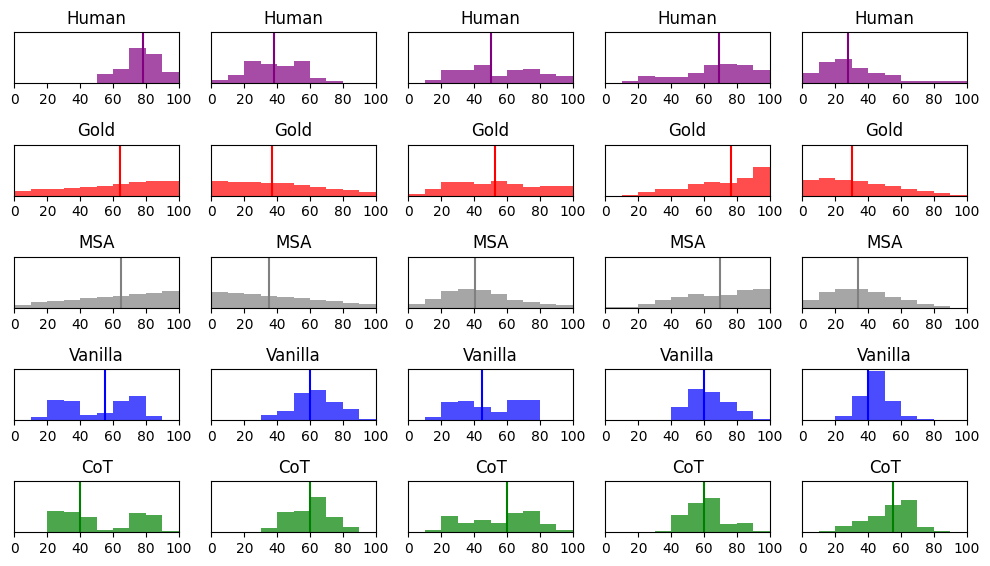

In [27]:
importlib.reload(analysis_utils)

alpha = 0.4


importlib.reload(analysis_utils)

processed_vals_all_srcs =analysis_utils.process_values_from_all_sources(
    all_scenarios=all_scenarios,
    llm_res=llm_res,
    baseline_human_data=baseline_human_data,
    all_inference_data=all_inference_data,
    gold_inference_data=all_gold_data,
    n_queries=n_queries,
    method="flat"
)



show_queries = [0, 2, 3, 5, 6]

sources = ["human_no_commentary", "gold", "model_full", "vanilla", "cot"]
# figsize =(12, 4)
figsize =(10, 6)
fig, axes = plt.subplots(len(sources), len(show_queries), figsize=figsize, sharey=True) 

scenario = "canoe-race_effort_team-explain-away-11-dec_win_how_much_explicit_continuous_variable"

scenario = "biathalon_shooting-accuracy_team-explain-away-confounded-opponent-partner-dec_win_how_much_explicit_continuous_variable"

# scenario = "tug-of-war_effort_team-weak-indirect-15-dec_win_how_much_implicit_continuous_variable"
# scenario = "biathalon_shooting-accuracy_team-explain-away-confounded-opponent-partner-dec_win_how_much_implicit_continuous_variable"

src2viz = {"human_no_commentary": "Human", "model_full": "MSA", "vanilla": "Vanilla", "cot": "CoT", 'gold': "Gold"}
src2color = {"human_no_commentary": "purple", "model_full": "grey", "vanilla": "blue", "cot": "green", 'gold': 'red'}

for q_idx, query in enumerate(show_queries):
    for src_idx, src in enumerate(sources): 
        vals = processed_vals_all_srcs[scenario][src]
        values_list = vals[query]
        ax = axes[src_idx, q_idx]
        ax.hist(values_list, color=src2color[src], alpha=0.7, bins=10, range=[0,100], density=True)
        
        med_val = np.median(values_list)
        ax.axvline(med_val, color=src2color[src])
    
        # Set title for model plots
        #ax.set_title(f"Query {query+1} ({src})")
        ax.set_title(src2viz[src])
        ax.set_xlim(0, 100)
        ax.set_xticks(np.arange(0, 101, 20))
        ax.set_yticks([])
        
plt.tight_layout(rect=[0, 0, 1, 0.96])
pth = f"splash_{scenario}.png"
plt.savefig(pth, dpi=300)



In [26]:
for s in baseline_human_data.keys():
    print(s)

diving_difficulty_team-explain-away-diverse-confounded-partner-dec_win_how_much_explicit_continuous_variable
canoe-race_effort_team-confounded-opponent-12-dec_win_how_much_explicit_continuous_variable
canoe-race_effort_team-strong-indirect-14-dec_win_how_much_explicit_continuous_variable
biathalon_shooting-accuracy_team-explain-away-confounded-opponent-partner-dec_win_how_much_explicit_continuous_variable
canoe-race_effort_team-explain-away-11-dec_win_how_much_explicit_continuous_variable
canoe-race_effort_team-confounded-partner-10-dec_win_how_much_explicit_continuous_variable
tug-of-war_effort_team-confounded-opponent-12-dec_win_how_much_explicit_continuous_variable
canoe-race_effort_team-explain-away-confounded-opponent-partner-dec_win_how_much_explicit_continuous_variable
biathalon_shooting-accuracy_team-explain-away-11b-dec_win_how_much_explicit_continuous_variable
tug-of-war_effort_team-explain-away-diverse-confounded-partner-dec_win_how_much_explicit_continuous_variable
tug-of-w

BACKGROUND

In this event, the athletes are competing in tug-of-war tournaments. Each tournament consists of a series of matches. In each match, athletes compete as part of a team. 



An athlete’s intrinsic strength remains constant throughout a tournament. An athlete neither gets stronger nor weaker between matches. You can assume that all matches take place on the same day.



Athletes also vary in the effort that they put into any given match. Most of the time, people pull with a moderately high amount of effort. Sometimes, an athlete won’t put in much effort and will pull with only a fraction of their strength. Other times, they may put in a lot of effort and pull extra hard, beyond what their intrinsic strength would suggest.



How hard a team pulls overall in any given match is determined by the total amount that all of the athletes on the team pull in that match. How hard each athlete pulls in a given match is determined by their intrinsic strength, modified by how much effort

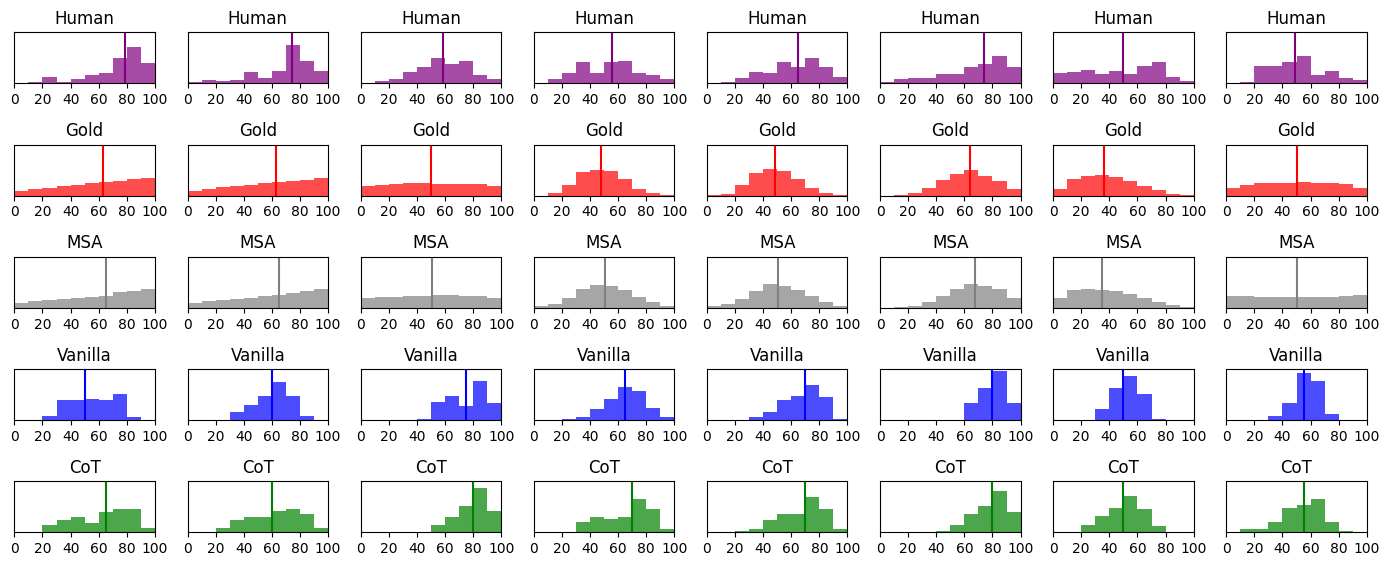

In [39]:
importlib.reload(analysis_utils)

alpha = 0.4


importlib.reload(analysis_utils)
processed_vals_all_srcs =analysis_utils.process_values_from_all_sources(
    all_scenarios=all_scenarios,
    llm_res=llm_res,
    baseline_human_data=baseline_human_data,
    all_inference_data=all_inference_data,
    gold_inference_data=all_gold_data,
    n_queries=n_queries,
    method="flat"
)



show_queries = [0, 1, 2, 4, 3, 5, 6, 7]

sources = ["human_no_commentary", "gold", "model_full", "vanilla", "cot"]
# figsize =(12, 4)
figsize =(14, 6)
fig, axes = plt.subplots(len(sources), len(show_queries), figsize=figsize, sharey=True) 

scenario = "canoe-race_effort_team-explain-away-11-dec_win_how_much_explicit_continuous_variable"

scenario = "tug-of-war_effort_team-weak-indirect-15-dec_win_how_much_implicit_continuous_variable"
scenario = "biathalon_shooting-accuracy_team-explain-away-confounded-opponent-partner-dec_win_how_much_implicit_continuous_variable"
scenario = "biathalon_shooting-accuracy_team-explain-away-confounded-opponent-partner-dec_win_how_much_explicit_continuous_variable"


scenario = "canoe-race_effort_team-explain-away-diverse-confounded-partner-dec_win_how_much_explicit_continuous_variable"

scenario = 'canoe-race_effort_team-confounded-opponent-12-dec_win_how_much_explicit_continuous_variable'
scenario = 'canoe-race_effort_team-explain-away-11-dec_win_how_much_explicit_continuous_variable'
scenario = "canoe-race_effort_team-explain-away-confounded-opponent-partner-dec_win_how_much_explicit_continuous_variable"
# scenario = "tug-of-war_effort_team-explain-away-confounded-opponent-partner-dec_win_how_much_implicit_continuous_variable"
scenario = "tug-of-war_effort_team-weak-indirect-15-dec_win_how_much_explicit_continuous_variable"
scenario = 'tug-of-war_effort_team-explain-away-confounded-opponent-partner-dec_win_how_much_explicit_continuous_variable'
scenario = 'tug-of-war_effort_team-explain-away-diverse-confounded-partner-dec_win_how_much_explicit_continuous_variable'

print("\n".join(stim2txt[scenario]))
# scenario = "tug-of-war_effort_team-explain-away-confounded-opponent-partner-dec_win_how_much_explicit_continuous_variable"


src2viz = {"human_no_commentary": "Human", "model_full": "MSA", "vanilla": "Vanilla", "cot": "CoT", 'gold': "Gold"}
src2color = {"human_no_commentary": "purple", "model_full": "grey", "vanilla": "blue", "cot": "green", 'gold': 'red'}

for q_idx, query in enumerate(show_queries):
    for src_idx, src in enumerate(sources): 
        vals = processed_vals_all_srcs[scenario][src]
        values_list = vals[query]
        ax = axes[src_idx, q_idx]
        ax.hist(values_list, color=src2color[src], alpha=0.7, bins=10, range=[0,100], density=True)
        
        med_val = np.median(values_list)
        ax.axvline(med_val, color=src2color[src])
    
        # Set title for model plots
        #ax.set_title(f"Query {query+1} ({src})")
        ax.set_title(src2viz[src])
        ax.set_xlim(0, 100)
        ax.set_xticks(np.arange(0, 101, 20))
        ax.set_yticks([])
        
plt.tight_layout(rect=[0, 0, 1, 0.96])
pth = f"splash_{scenario}.png"
plt.savefig(pth, dpi=300)



KeyError: 'biathalon_shooting-accuracy_team-explain-away-confounded-opponent-partner-dec_win_how_much_implicit_continuous_variable'

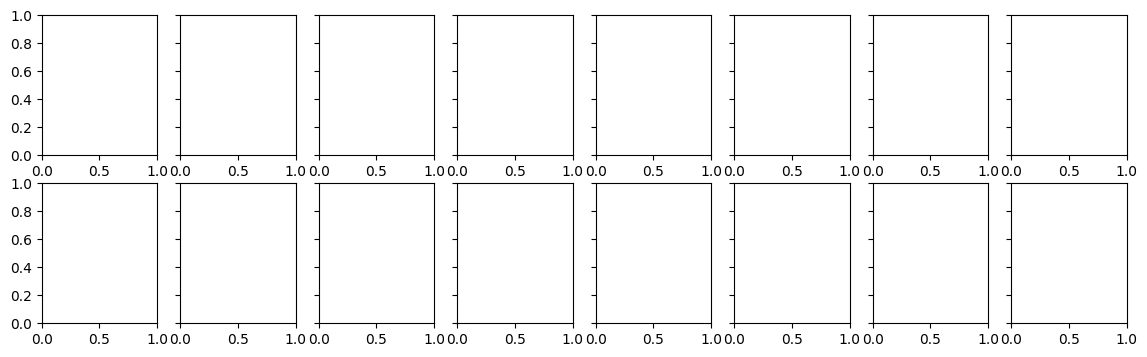

In [52]:
# importlib.reload(analysis_utils)

# alpha = 0.4


# show_queries = [0, 1, 2, 4, 3, 5, 6, 7]

# sources = ["human_no_commentary",# "gold", 
#            "model_full",]
# # figsize =(12, 4)
# figsize =(14, 4)
# fig, axes = plt.subplots(len(sources), len(show_queries), figsize=figsize, sharey=True) 

# scenario = "biathalon_shooting-accuracy_team-weak-indirect-15-dec_win_how_much_explicit_continuous_variable" #"biathalon_shooting-accuracy_team-explain-away-confounded-opponent-partner-dec_win_how_much_explicit_continuous_variable"

# scenario = "biathalon_shooting-accuracy_team-confounded-partner-10-dec_win_how_much_implicit_continuous_variable"
# scenario ="canoe-race_effort_team-strong-indirect-14-dec_win_how_much_implicit_continuous_variable"

# scenario = "biathalon_shooting-accuracy_team-explain-away-confounded-opponent-partner-dec_win_how_much_implicit_continuous_variable"
# src2viz = {"human_no_commentary": "Human", "model_full": "MSA", "vanilla": "Vanilla", "cot": "CoT", 'gold': "Gold"}
# src2color = {"human_no_commentary": "purple", "model_full": "grey", "vanilla": "blue", "cot": "green", 'gold': 'red'}

# for q_idx, query in enumerate(show_queries):
#     for src_idx, src in enumerate(sources): 
#         vals = processed_vals_all_srcs[scenario][src]
#         values_list = vals[query]
#         ax = axes[src_idx, q_idx]
#         ax.hist(values_list, color=src2color[src], alpha=0.7, bins=10, range=[0,100], density=True)
        
#         med_val = np.median(values_list)
#         ax.axvline(med_val, color=src2color[src])
    
#         # Set title for model plots
#         #ax.set_title(f"Query {query+1} ({src})")
#         ax.set_title(src2viz[src])
#         ax.set_xlim(0, 100)
#         ax.set_xticks(np.arange(0, 101, 20))
#         ax.set_yticks([])
        
# plt.tight_layout(rect=[0, 0, 1, 0.96])
# pth = f"splash_{scenario}.png"
# plt.savefig(pth, dpi=300)



In [19]:
vals= baseline_human_data[scenario]
vals

[{'query1': [83],
  'query2': [46],
  'query3': [52],
  'query4': [42],
  'query5': [50],
  'query6': [51],
  'query7': [63],
  'query8': [58]},
 {'query1': [98, 96, 91, 87, 84],
  'query2': [99, 95, 91, 85, 80],
  'query3': [52, 43, 33, 23, 10],
  'query4': [53, 47, 41, 36, 29],
  'query5': [62, 57, 45, 34, 29],
  'query6': [89, 85, 82, 77, 73],
  'query7': [9, 15, 20, 26, 61],
  'query8': [7, 15, 25, 30, 56]},
 {'query1': [75, 91, 94, 83, 79],
  'query2': [78, 86, 75, 93, 65],
  'query3': [41, 23, 8, 15, 25],
  'query4': [74, 87, 94, 82, 62],
  'query5': [57, 77, 87, 92, 82],
  'query6': [32, 21, 13, 24, 28],
  'query7': [77, 85, 89, 83, 72],
  'query8': [84, 80, 73, 69, 89]},
 {'query1': [100, 98, 94, 90],
  'query2': [94, 92, 89, 85],
  'query3': [61, 56, 50, 48],
  'query4': [62, 57, 52, 47],
  'query5': [67, 64, 58, 73],
  'query6': [59, 46, 46, 52],
  'query7': [92, 92, 86, 70, 78],
  'query8': [61, 67, 54, 54, 72]},
 {'query1': [70, 61, 57, 44, 50],
  'query2': [57, 62, 73, 69]

In [18]:
vals = processed_vals_all_srcs[scenario]['human_no_commentary']
vals[7]

[58,
 7,
 15,
 25,
 30,
 56,
 84,
 80,
 73,
 69,
 89,
 61,
 67,
 54,
 54,
 72,
 54,
 47,
 50,
 38,
 45,
 4,
 4,
 7,
 15,
 10,
 5,
 17,
 40,
 41,
 42,
 44,
 46,
 6,
 9,
 13,
 18,
 23,
 48,
 50,
 50,
 53,
 57,
 51,
 2,
 8,
 12,
 19,
 27,
 12,
 1,
 5,
 13,
 7,
 50,
 62,
 76,
 33,
 23,
 21,
 51,
 45,
 41,
 37,
 33]

In [65]:
vals = analysis_utils.process_query_values(
            baseline_human_data[scenario], n_queries,method="flat"
        )
vals

{0: [50,
  24,
  27,
  19,
  7,
  11,
  11,
  11,
  11,
  11,
  25,
  36,
  49,
  10,
  18,
  23,
  31,
  30,
  30,
  34,
  4,
  27,
  17,
  38,
  22,
  34,
  39,
  47,
  54,
  58,
  30,
  36,
  45,
  53,
  53,
  66,
  74,
  81,
  91,
  98,
  47,
  44,
  25,
  29,
  35,
  47,
  39,
  28,
  18,
  11,
  45,
  37,
  40,
  35,
  38,
  78,
  81,
  84,
  87,
  91,
  9,
  17,
  21,
  24,
  29,
  44,
  47,
  50,
  41,
  53,
  82,
  84,
  86,
  89,
  85,
  50,
  46,
  48,
  52,
  54,
  24,
  24,
  29,
  34,
  20,
  1,
  1,
  1,
  1,
  1],
 1: [50,
  60,
  35,
  42,
  55,
  67,
  67,
  67,
  67,
  67,
  64,
  77,
  88,
  96,
  52,
  85,
  79,
  77,
  71,
  68,
  94,
  88,
  84,
  67,
  76,
  78,
  83,
  86,
  90,
  80,
  58,
  62,
  66,
  73,
  53,
  63,
  75,
  84,
  92,
  99,
  59,
  75,
  72,
  80,
  85,
  45,
  56,
  66,
  78,
  71,
  62,
  72,
  66,
  70,
  68,
  97,
  95,
  92,
  88,
  91,
  76,
  83,
  71,
  66,
  80,
  50,
  52,
  54,
  56,
  59,
  80,
  83,
  76,
  78,
  84,
  74,
  76,

In [73]:
import numpy as np
from scipy import stats
from sklearn.mixture import GaussianMixture
from diptest import diptest

def analyze_multimodality(data, max_components=5):
    # Hartigan's dip test
    dip, pval = diptest(data)
    
    # GMM with BIC
    bic_scores = []
    models = []
    n_components_range = range(1, max_components + 1)
    
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, random_state=42)
        gmm.fit(data.reshape(-1, 1))
        bic_scores.append(gmm.bic(data.reshape(-1, 1)))
        models.append(gmm)
    
    optimal_n_components = n_components_range[np.argmin(bic_scores)]
    
    return {
        'dip_statistic': dip,
        'dip_p_value': pval,
        'optimal_n_components': optimal_n_components,
        'bic_scores': bic_scores
    }

# For each distribution in your data:
results = []
from scipy import stats
for query, values_list in vals.items():
    result = analyze_multimodality(np.array(values_list))
    results.append(result)
    kurtosis = stats.kurtosis(values_list)
    print(query, kurtosis)

0 -0.35487146237501266
1 -0.3484765001988981
2 -0.4136500500927247
3 -0.8532480840388752
4 -0.5305700199460035
5 -1.073904350779229
6 -0.9701553711164235
7 -0.5810840686436216


In [69]:
results

[{'dip_statistic': 0.038588588588588595,
  'dip_p_value': 0.43368294439847965,
  'optimal_n_components': 3,
  'bic_scores': [np.float64(842.2661510615541),
   np.float64(843.6937737767836),
   np.float64(836.3342656720907),
   np.float64(845.2585849491604),
   np.float64(856.1223432464363)]},
 {'dip_statistic': 0.042222222222222223,
  'dip_p_value': 0.28416479880486656,
  'optimal_n_components': 1,
  'bic_scores': [np.float64(741.2573960841739),
   np.float64(750.5528505554404),
   np.float64(762.94074244653),
   np.float64(773.475372587007),
   np.float64(780.251095528753)]},
 {'dip_statistic': 0.03333333333333334,
  'dip_p_value': 0.6993970404276834,
  'optimal_n_components': 1,
  'bic_scores': [np.float64(816.9520804241113),
   np.float64(830.4478702861041),
   np.float64(827.9296141167035),
   np.float64(834.5883090867974),
   np.float64(848.2087316039799)]},
 {'dip_statistic': 0.04148148148148148,
  'dip_p_value': 0.31049219413523865,
  'optimal_n_components': 3,
  'bic_scores': [

In [72]:
for entry in baseline_human_data[scenario]:
    print(entry['query6'])

[39, 24, 30, 44, 15]
[48, 48, 48, 48, 48]
[73, 85, 98, 64, 91]
[56, 50, 50, 42, 42]
[86, 73, 67, 35, 94]
[85, 85, 91, 79, 82]
[45, 49, 54, 59, 64]
[37, 50, 62, 62, 70]
[21, 17, 12, 25, 30]
[68, 76, 81, 87, 93]
[93, 96, 92, 98, 96]
[4, 6, 10, 14, 16]
[74, 66, 60, 48, 41]
[85, 87, 91, 94, 82]
[18, 20, 12, 14, 15]
[99, 100, 97, 97, 94]
[87, 82, 79, 100, 95]
[77, 77, 77, 77, 77]


In [59]:
baseline_human_data[scenario]

[{'query1': [50, 24, 27, 19, 7],
  'query2': [50, 60, 35, 42, 55],
  'query3': [7, 15, 25, 39, 35],
  'query4': [51, 64, 57, 37, 43],
  'query5': [61, 57, 66, 42, 47],
  'query6': [39, 24, 30, 44, 15],
  'query7': [37, 68, 51, 86, 32],
  'query8': [50, 66, 78, 33, 57]},
 {'query1': [11, 11, 11, 11, 11],
  'query2': [67, 67, 67, 67, 67],
  'query3': [48, 48, 48, 48, 48],
  'query4': [9, 9, 9, 9, 9],
  'query5': [15, 15, 15, 15, 15],
  'query6': [48, 48, 48, 48, 48],
  'query7': [35, 35, 35, 35, 35],
  'query8': [40, 40, 40, 40, 40]},
 {'query1': [25, 36, 49, 10, 18],
  'query2': [64, 77, 88, 96, 52],
  'query3': [29, 41, 55, 74, 63],
  'query4': [6, 34, 70, 97, 52],
  'query5': [52, 76, 99, 63, 85],
  'query6': [73, 85, 98, 64, 91],
  'query7': [67, 79, 96, 62, 88],
  'query8': [28, 45, 54, 73, 61]},
 {'query1': [23, 31, 30, 30, 34],
  'query2': [85, 79, 77, 71, 68],
  'query3': [39, 52, 43, 34, 35],
  'query4': [66, 59, 56, 49, 43],
  'query5': [93, 93, 83, 78, 78],
  'query6': [56, 50